In [32]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax import random

import pandas as pd
import matplotlib.pyplot as plt

import time
import sys
import os

p = os.path.abspath(os.path.join('..', '00_utils'))

# Add the directory to sys.path
if p not in sys.path:
    sys.path.append(p)

from collocation import compute_weights, lagrange_derivative
#from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
#from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
#from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
# RELOADING MODULES
import importlib
import neural_net_jax
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

import data_generation
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

# ----------------- diffrax code -----------------
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.nn as jnn
import jax.random as jr
import optax  # https://github.com/deepmind/optax


In [33]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 400
noise_level = 0.05
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [34]:
u_noisy = np.atleast_2d(y_noisy).T
r, c = u_noisy.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 400; c : 1
r : 400; c : 1


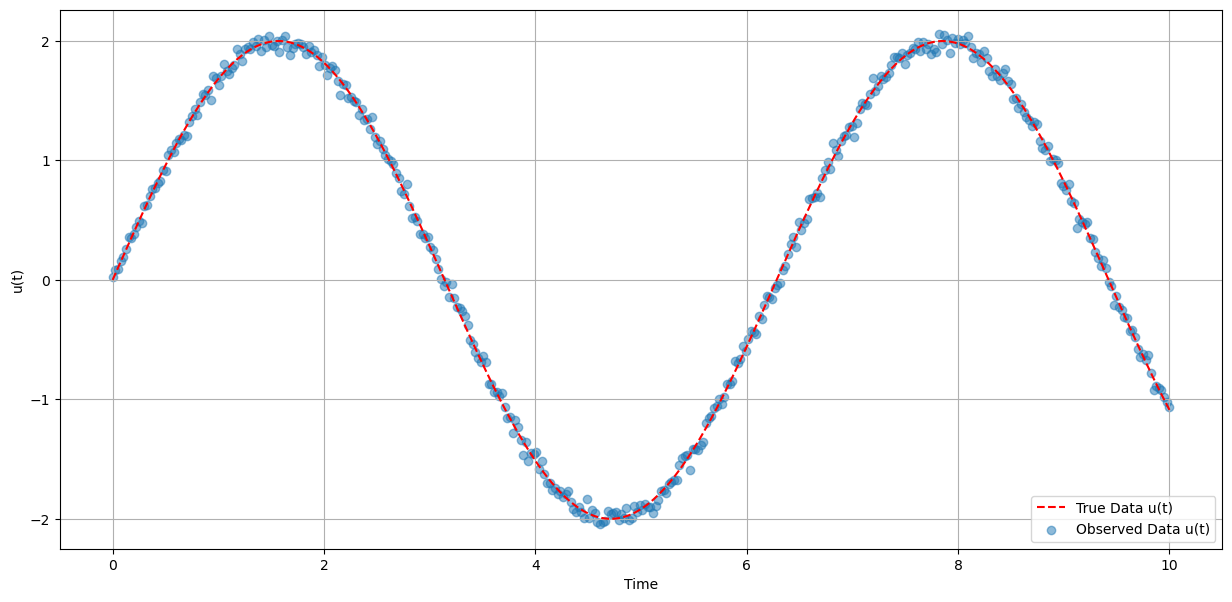

In [35]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')

plt.plot(t, y, 'r--', label='True Data u(t)') 
plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `Regular JAX Odeint training`

In [36]:
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

In [38]:
y_pred_results = {}
n = 50

layer_widths = [1, 64, 64, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)

for i in [50, 100, N]:
    print(i)
    state = node_model.train(state, t[:i], u_noisy[:i], y[0], num_epochs = 1000)
#state = node_model.train(state, t, u_noisy, y[0], num_epochs = 1000)

50
Epoch 0, Loss: 1.497882126461861
Epoch 100, Loss: 0.042795534182635826
Epoch 200, Loss: 0.02086383068995275
Epoch 300, Loss: 0.01607212937590375
Epoch 400, Loss: 0.015027233879430092
Epoch 500, Loss: 0.014562906016781712
Epoch 600, Loss: 0.014168059962744894
Epoch 700, Loss: 0.013786319679138598
Epoch 800, Loss: 0.013412862974764619
Epoch 900, Loss: 0.01304701219234983
100
Epoch 0, Loss: 0.612384167744213
Epoch 100, Loss: 0.08381196563646988
Epoch 200, Loss: 0.07345275868145654
Epoch 300, Loss: 0.07071630253814674
Epoch 400, Loss: 0.06489807018620188
Epoch 500, Loss: 0.0608802956850672
Epoch 600, Loss: 0.05750414928719083
Epoch 700, Loss: 0.055094692241283286
Epoch 800, Loss: 0.05403113495130169
Epoch 900, Loss: 0.05445658193981751
400
Epoch 0, Loss: 4.01250797639062
Epoch 100, Loss: 1.7817380186090361
Epoch 200, Loss: 1.781431032027122
Epoch 300, Loss: 1.7811621835805358
Epoch 400, Loss: 1.7810073427181334
Epoch 500, Loss: 1.780694967144154
Epoch 600, Loss: 1.7805469523475057
Epoch

In [39]:
y_train_pred = node_model.neural_ode(state.params, y[0], t, state)
y_test_pred = node_model.neural_ode(state.params, y_test[0], t_test, state)

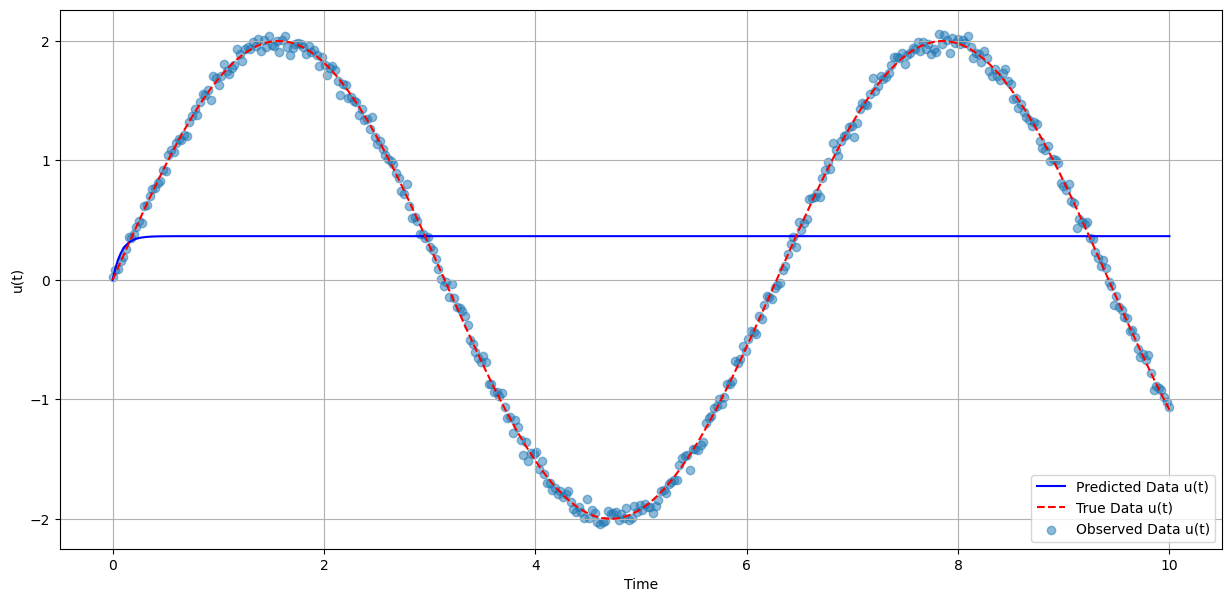

In [41]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')

plt.plot(t, y_train_pred, 'b', label='Predicted Data u(t)') 
plt.plot(t, y, 'r--', label='True Data u(t)') 
plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 
#plt.scatter(t[:i], u_noisy[:i], label='Observed Data u(t)', alpha=1) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()